In [111]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from pylab import cm

from sklearn.manifold import TSNE

In [112]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 256

lr = 0.001

In [113]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, torch.sign(activation_1)
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 256)
  (fc2): Linear (256 -> 10)
)


In [114]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        cmap = cm.get_cmap('PiYG', 5)
        plt.imshow(np.corrcoef(self.train_activations.transpose()), cmap=cmap, interpolation='nearest', vmax=1., vmin=-1.)
        plt.colorbar()
        plt.show()
        #         bins = range(0, hidden_layer_size)
        #         indexes1 = np.random.choice(self.train_activations.shape[0], 10000)
        #         indexes2 = np.random.choice(self.train_activations.shape[0], 10000)

        #         distances = np.abs(self.train_activations[indexes1] - self.train_activations[indexes2]).sum(1)
        #         plt.hist(distances, bins, label='Train Activations')

        #         indexes1 = np.random.choice(self.test_activations.shape[0], 10000)
        #         indexes2 = np.random.choice(self.test_activations.shape[0], 10000)

        #         distances = np.abs(self.test_activations[indexes1] - self.train_activations[indexes2]).sum(1)
        #         plt.hist(distances, bins, label='Test Activations')

        #         plt.legend()
        #         plt.title('Histogram of distances of activation patterns')
        #         plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [115]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [116]:
if cuda:
    model.cuda()
    criterion.cuda()

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
        
    metrics.print_metrics()
    return metrics

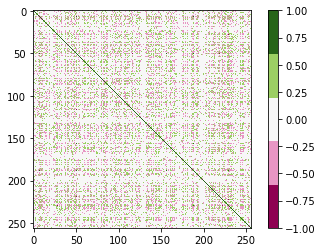

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.290098
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.908270
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.512398
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.610112
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.691381
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.770148
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.717819
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.455256

Test set: Average loss: 1.5502, Accuracy: 4573/10000 (46%)



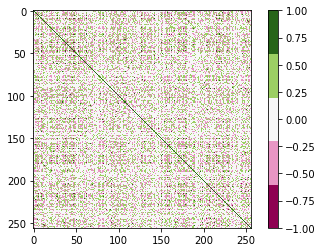

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.512818
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.246930
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.439241
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.599584
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.709443
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.431784
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.282679
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.384103

Test set: Average loss: 1.4621, Accuracy: 4912/10000 (49%)



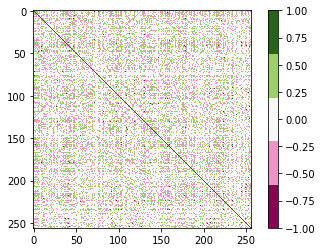

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.394021
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.270225
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.114759
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.615450
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.056797
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.214292
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.217908
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.453135

Test set: Average loss: 1.4016, Accuracy: 5051/10000 (51%)



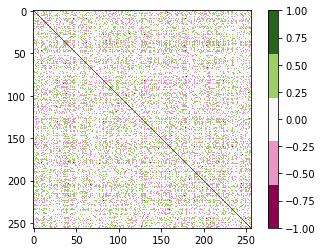

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.272165
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.278185
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.065773
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.268710
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.346727
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.178284
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.367144
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.225364

Test set: Average loss: 1.3730, Accuracy: 5210/10000 (52%)



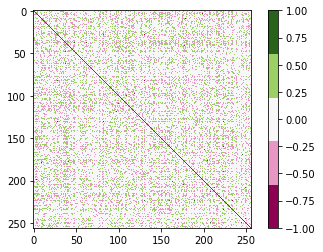

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.365214
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.293561
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.228002
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.180830
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.977239
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.525177
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.043031
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.263664

Test set: Average loss: 1.3857, Accuracy: 5123/10000 (51%)



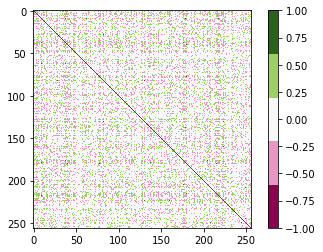

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.209946
Train Epoch: 6 [6400/50000 (13%)]	Loss: 0.940079
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.174075
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.803891


In [ ]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()